# Shifterator

We load the articles and create two dictionaries where keys are word types and values are their frequencies for each media ideology.

In [1]:
# import modules
import pandas as pd
import shifterator as sh
from nltk import text
from nltk.tokenize import word_tokenize
import spacy
from spacy.language import Language
import numpy as np
import nltk
nltk.download('punkt')
from tqdm import tqdm

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('preprocessed.csv', encoding='utf-8')
df.head()  

,date,maintext,title,source,media_name,ideology,Congress,text
0,2015/02/13,Advertisement\r\r\nIn honor of our 95 annivers...,6 Ways the League of Women Voters Has Impacted...,http://www.huffingtonpost.com/elisabeth-macnam...,Huffington Post,left,114th,"honor 95 anniversary, list things americans pa..."
1,2015/02/10,"As state legislatures shift into high gear, ma...",Opportunities for Effective Election Reforms C...,http://www.huffingtonpost.com/robert-m-brandon...,Huffington Post,left,114th,"state legislatures shift high gear, election r..."
2,2015/02/22,"FILE - In a Tuesday, Nov. 4, 2014 file photo, ...","Scott Walker Pushes ALEC 'Right to Work' Bill,...",http://www.huffingtonpost.com/mary-bottari/sco...,Huffington Post,left,114th,"file - tuesday, nov. 4, 2014 file photo, wisco..."
3,2015/02/25,Former Ohio Gov. Ted Strickland (D) announced ...,Ted Strickland Announces He's Running For The ...,http://www.huffingtonpost.com/2015/02/25/ted-s...,Huffington Post,left,114th,ohio gov. ted strickland (d) announced wednesd...
4,2015/02/26,Nevada Senate Minority Leader Michael Roberson...,Nevada GOP Pushes New Gun Law Reminiscent Of '...,http://www.huffingtonpost.com/2015/02/26/nevad...,Huffington Post,left,114th,nevada senate minority leader michael roberson...


In [3]:
nlp = spacy.load("en_core_web_sm") 
stopwords = nlp.Defaults.stop_words

#add extra words you want to exclude
nlp.Defaults.stop_words.add('advertisement') 
nlp.Defaults.stop_words.add('s')
nlp.Defaults.stop_words.add('placeholder')
nlp.Defaults.stop_words.add('t')

print(nlp.Defaults.stop_words)

{'though', 'by', 'hence', 'fifteen', 'many', 'whatever', '’ve', 'such', 'various', 'seemed', 'take', 'around', 'ever', 'several', 'twelve', 'most', 'hereby', 'is', 'not', 'on', 'below', 'until', 'anywhere', 'became', 'noone', 'move', 'itself', 'were', 'the', 'else', 'per', 'elsewhere', 'even', 'thereafter', 'what', 'yet', 'before', 'whereafter', 'another', 'towards', 'hundred', 'always', 'they', 'call', 'side', 'sixty', 'really', 'become', 'all', 'mine', 'their', 'your', 'somewhere', 'enough', 'wherein', 'onto', 'five', 'everything', 'moreover', 'my', 'own', 'regarding', 'where', 'into', 'be', 'since', 'namely', 'whoever', 'meanwhile', 'she', 'her', 'full', 'across', 'latterly', 'thence', 'these', 'three', 'done', 'more', "'ve", 'eight', 'however', 'very', 'any', 'there', 'at', 'up', 'nine', 'toward', 'never', 'fifty', 'whereupon', 'back', 'you', 'somehow', 'behind', 'because', 'beyond', 'forty', 'go', 'indeed', 'other', 'see', 'whither', 'nowhere', 'upon', 'yourselves', 'well', 'again

In [4]:
#con only do this once
#this makes sure that the tokenization considers entities

class EntityRetokenizeComponent:
    def __init__(self, nlp):
        pass

    def __call__(self, doc):
        with doc.retokenize() as retokenizer:
            for ent in doc.ents:
                retokenizer.merge(doc[ent.start:ent.end], attrs={"LEMMA": str(doc[ent.start:ent.end])})
        return doc

@Language.factory("entity_retokenizer_component")
def create_entity_retokenizer_component(nlp, name):
    return EntityRetokenizeComponent(nlp)

nlp = spacy.load("en_core_web_sm")  
nlp.add_pipe("entity_retokenizer_component", name='merge_phrases', last=True)


#rule to prevent spacy from splitting ID into I & D
nlp.tokenizer.rules = {key: value for key, value in nlp.tokenizer.rules.items() if key != "id"}

In [5]:
#preprocess the text 
def preprocessing(corpus):
    '''this function preprocesses text. 
    It creates tokens, lowercases, 
    checks if str elements are actual words, 
    and then appends them to a list of clean '''
    # initialize
    clean_text = []

    for row in corpus:
        tokens = [token.text for token in nlp(row)] #spacy
        #word tokenize
        #tokens = word_tokenize(row) #nltk
        #lowercase
        tokens = [token.lower() for token in tokens]
        # isword
        tokens = [token for token in tokens if token.isalpha()]
        #remove stopwords
        tokens = [word for word in tokens if not word in nlp.Defaults.stop_words]
        clean_sentence = ''
        clean_sentence = ' '.join(token for token in tokens)
        clean_text.append(clean_sentence)
       
    return clean_text
 

In [6]:
df['cleantext'] = preprocessing(df.astype(str)['maintext'])

In [ ]:
#this is no longer necessary

#define stopwords
#from nltk.corpus import stopwords
#stopwords = stopwords.words('english')
#remove stopwords
#df['cleantext'] = df['cleantext'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [7]:
# creating two different datasets for media split by ideology
ideology = df.groupby("ideology")
left = ideology.get_group('left')
right = ideology.get_group('right')

In [8]:
left_text =left['cleantext'].apply(str) # left leaning media
right_text= right['cleantext'].apply(str) # right leaning media

In [9]:
tokens_right = [" ".join(strings.split()) for strings in right_text] 

In [10]:
tokens_left = []
for sentence in tqdm(left_text):
    tokenized = (token.text for token in nlp(sentence))
    tokens = [" ".join(tokenized)]
    tokens_left.extend(tokens)

100%|██████████| 2753/2753 [03:07<00:00, 14.66it/s]


In [11]:
string_left = " ".join(tokens_left)

In [12]:
tokens_right = []
for sentence in tqdm(right_text):
    tokenized = (token.text for token in nlp(sentence))
    tokens = [" ".join(tokenized)]
    tokens_right.extend(tokens)

100%|██████████| 1714/1714 [01:19<00:00, 21.47it/s]


In [13]:
string_right = " ".join(tokens_right)

In [14]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [15]:
left_dic = word_count(string_left)
right_dic = word_count(string_right)

### Frequency-Based Shifts
Many word shifts can be constructed using only the frequency counts of how often words appear in each of two texts. The frequencies should be loaded into two dictionaries type2freq_1 and type2freq_2, where keys are word types and values indicate how many times that word appeared in that text.



/opt/conda/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


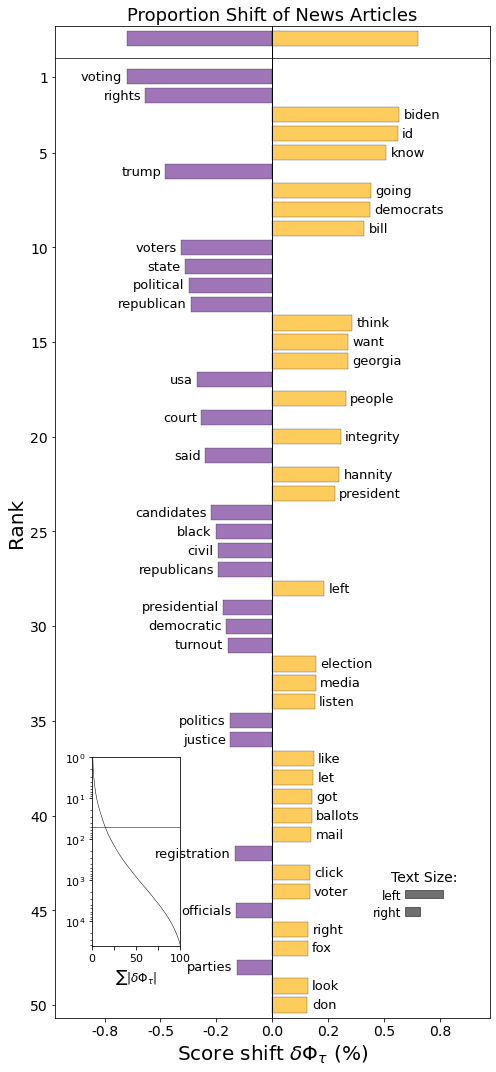

<AxesSubplot:title={'center':'Proportion Shift of News Articles'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [16]:
proportion_shift = sh.ProportionShift(type2freq_1=left_dic, type2freq_2=right_dic)
proportion_shift.get_shift_graph(system_names = ['left', 'right'], top_n=50, title='Proportion Shift of News Articles')

### Shannon entropy word shift

Proportion shifts are easy to interpret, but they are simplistic and have a difficult time pulling out interesting differences between two texts. For example, we see many “stop words” in the proportion shift. Instead, we can use the Shannon entropy to identify more “surprising” words and how they vary between two texts. The less often a word appears in a text, the more surprising that it is. The Shannon entropy can be interpreted as the average surprisal of a text. We can compare two texts by taking the difference between their entropies. We can rank these contributions and plot them as a Shannon entropy word shift. If the contribution is positive, then the word has a higher score in the second text. If the contribution is negative, then its score is higher in the first text.

/opt/conda/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


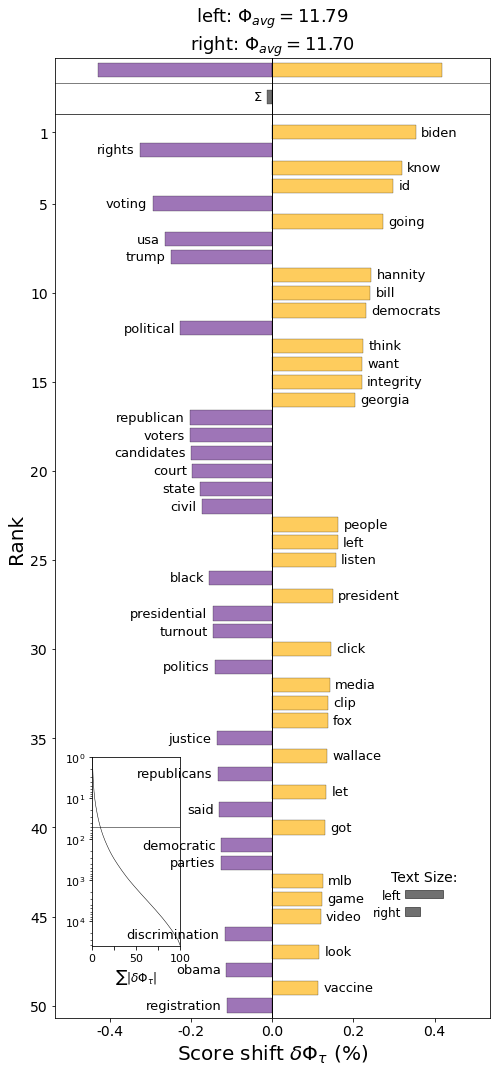

<AxesSubplot:title={'center':'left: $\\Phi_{avg}=$11.79\nright: $\\Phi_{avg}=$11.70'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [17]:
entropy_shift = sh.EntropyShift(type2freq_1=left_dic,
                                type2freq_2=right_dic,
                                base=2)
shift = entropy_shift.get_shift_graph(system_names = ['left', 'right'], top_n=50)
shift

In [18]:
test_dict=entropy_shift.get_shift_scores()

In [19]:
df2 = pd.DataFrame.from_dict({'score': list(test_dict.values()), 'word': list(test_dict.keys())})
df2

,score,word
0,-4.845577e-05,complex
1,-7.396633e-06,donkey
2,5.897889e-06,precusor
3,-9.150225e-06,busch
4,6.879791e-07,emphasizing
...,...,...
41163,1.599121e-05,instant
41164,2.035070e-06,disturbance
41165,-1.006764e-05,prestigious
41166,-2.533051e-06,pinatas


In [20]:
df2['left_right'] = np.where(df2['score']<0, 'left', 'right')

In [21]:
df2.sort_values(by = 'score', ascending = False)

,score,word,left_right
12503,0.003530,biden,right
21881,0.003185,know,right
28769,0.002977,id,right
40431,0.002727,going,right
34863,0.002439,hannity,right
...,...,...,...
7661,-0.002268,political,left
13663,-0.002503,trump,left
27263,-0.002650,usa,left
30856,-0.002949,voting,left


In [ ]:
#get a sample 
#df3 = df2.sample(400)

In [22]:
df2.to_csv('shifterator_2.csv', index=False)

In [23]:
wordlist = df2['word'].astype(str).to_list()

In [24]:
len(wordlist)
with open('shiftwords_2.txt', 'w') as f:
    for element in wordlist:
        f.write(element + "\n")